# Neural architecture Search

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/2-Neural-Architecture-Search.ipynb)

Developing surrogate geophysical models from data is a key research topic in atmospheric and oceanic modeling because of the large computational costs associated with numerical simulation methods. Researchers have started applying a wide range of machine learning models, in particular neural networks, to geophysical data for forecasting without these constraints. Constructing neural networks for forecasting such data is nontrivial, however, and often requires trial and error. 

We focus on a particularly promising approach for nonintrusive modeling (or forecasting) involving the use of linear
dimensionality reduction followed by recurrent neural network time evolution. This forecast technique compresses the spatiotemporal field into its dominant principal components by using proper orthogonal decomposition (POD) (also known as principal components analysis). Following this, the coefficients of each component are evolved by using a time series method. In recent literature, long short-term memory networks (LSTMs), a variant of recurrent neural networks, have been used extensively for modeling temporally varying POD coefficients. The construction of an LSTM architecture for this purpose is generally based on trial and error, requires human expertise, and consumes significant development time. For more details see [1].

[1] R. Maulik, R. Egele, B. Lusch, and P. Balaprakash. "Recurrent neural network architecture search for geophysical emulation." In SC20: International Conference for High Performance Computing, Networking, Storage and Analysis, pp. 1-14. IEEE, 2020. https://arxiv.org/abs/2004.10928

In this notebook, we will start with a manually designed simple POD-LSTM and show how to improve its accuracy using DeepHyper's neural architecture search.

In [1]:
IN_COLAB = False
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)

False


In [2]:
#Install dependencies if running in google collab
if IN_COLAB:
    !rm -rf deephyper_repo/
    !git clone -b develop https://github.com/deephyper/deephyper.git deephyper_repo
    !pip install -e "deephyper_repo/[nas,popt,autodeuq]" --use-feature=in-tree-build
    !pip install matplotlib==3.5.2
    !git clone https://github.com/deephyper/anl-22-summer-workshop.git

In [3]:
# Download the data if running in google collab
if IN_COLAB:
    %cd /content/anl-22-summer-workshop/notebooks/data
    !gdown 1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
    !gdown 1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
    !gdown 1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU
    %cd /content/anl-22-summer-workshop/notebooks/

In [4]:
import gzip

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data.utils import load_sst_data, load_data_prepared

from deephyper.nas.metrics import r2

## The data

Let's start by loading the raw training data with shape `(timestep, latitude, longitude)` containing temperature with Celsius as unit

In [5]:
train_data, test_data, mask = load_sst_data()
train_data.shape

(427, 180, 360)

Then we can visualize a specific timestep (the first week), let's try with the first one.

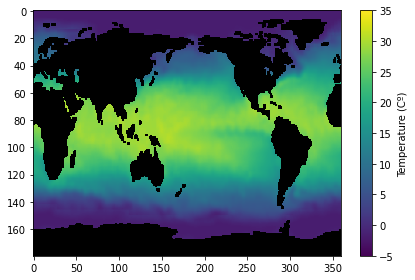

In [6]:
palette = plt.cm.viridis.with_extremes(over='r', under='r', bad='black')

idx = 0
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure()
im = plt.imshow(snapshot_masked, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()
plt.show()

## Baseline LSTM Model

In [7]:
def build_and_train_model(config: dict, n_components: int = 5, verbose: bool = 0):
    tf.keras.utils.set_random_seed(42)

    default_config = {
        "lstm_units": 128,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "learning_rate": 1e-3,
        "batch_size": 64,
        "dropout_rate": 0,
        "num_layers": 1,
        "epochs": 20,
    }
    default_config.update(config)

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared(
        n_components=n_components
    )

    layers = []
    for _ in range(default_config["num_layers"]):
        lstm_layer = tf.keras.layers.LSTM(
            default_config["lstm_units"],
            activation=default_config["activation"],
            recurrent_activation=default_config["recurrent_activation"],
            return_sequences=True,
        )
        dropout_layer = tf.keras.layers.Dropout(default_config["dropout_rate"])
        layers.extend([lstm_layer, dropout_layer])

    model = tf.keras.Sequential(
        [tf.keras.Input(shape=X_train.shape[1:])]
        + layers
        + [tf.keras.layers.Dense(n_components)]
    )

    if verbose:
        model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=default_config["learning_rate"])
    model.compile(optimizer, "mse", metrics=[])

    history = model.fit(
        X_train,
        y_train,
        epochs=default_config["epochs"],
        batch_size=default_config["batch_size"],
        validation_data=(X_valid, y_valid),
        verbose=verbose,
    ).history

    return model, history

In [8]:
n_components = 5

model, history = build_and_train_model(config={}, n_components=n_components, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 dense (Dense)               (None, 8, 5)              645       
                                                                 
Total params: 69,253
Trainable params: 69,253
Non-trainable params: 0
_________________________________________________________________


2022-07-09 14:28:24.255161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
14/14 [==============================] - 2s 33ms/step - loss: 0.1763 - val_loss: 0.1014
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.0855 - val_loss: 0.0696
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0602 - val_loss: 0.0499
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0447 - val_loss: 0.0397
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0372 - val_loss: 0.0338
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0322 - val_loss: 0.0298
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0287 - val_loss: 0.0266
Epoch 8/20
14/14 [==============================] - 0s 8ms/step - loss: 0.0257 - val_loss: 0.0240
Epoch 9/20
14/14 [==============================] - 0s 8ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 10/20
14/14 [==============================] - 0s 8ms/step - loss: 0.0212 - val_loss: 0.0200
Epoch 11/20
14/14 

Let us check the learning performance of this baseline

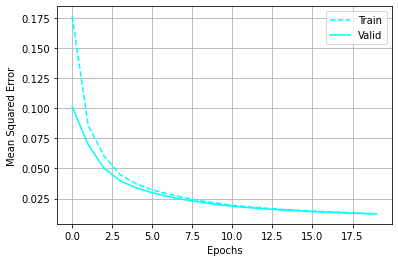

In [9]:
plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="--", label="Train")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show()

In [10]:
cached_data = f"processed_data_{n_components}_8_8.npz"
with gzip.GzipFile(cached_data, "rb") as f:
    data = np.load(f, allow_pickle=True).item()
    X_train, y_train = data["train"]
    X_valid, y_valid = data["valid"]
    X_test, y_test = data["test"]
    preprocessor = data["preprocessor"]

y_pred = model.predict(X_train)
shape = y_pred.shape
y_pred = y_pred.reshape(-1, shape[-1])
y_pred = preprocessor.inverse_transform(y_pred).reshape((*shape[:2], -1))

28/28 [==============================] - 0s 2ms/step


We can also visualize a prediction

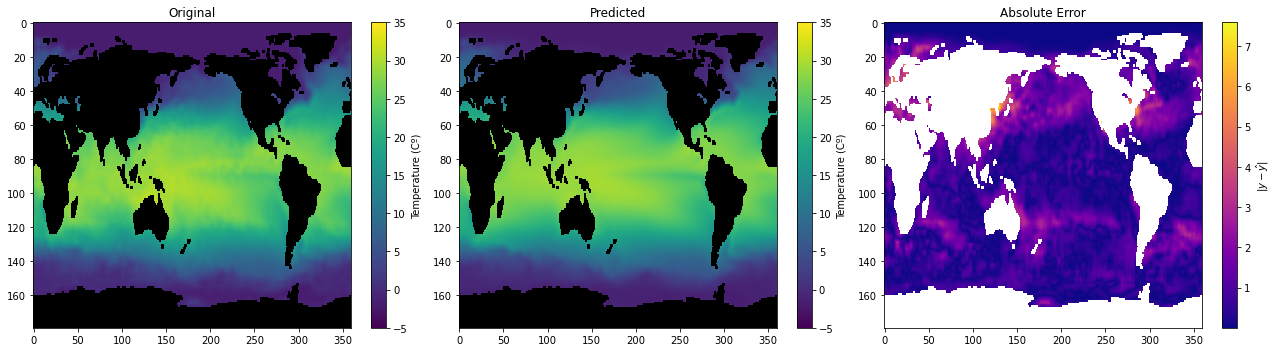

In [11]:
idx = 9 # should be > than input_horizon!
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_y_pred = y_pred[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_y_pred.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
ax.set_title("Predicted")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
ax.set_title("Absolute Error")
err = np.abs(snapshot_masked_full - snapshot_masked_redu)
im = plt.imshow(err, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$|y - \hat{y}|$")
plt.tight_layout()

plt.show()

In [12]:
from deephyper.nas.metrics import r2, mse

scores = {"MSE": mse, "R2": r2}

for metric_name, metric_func in scores.items():
    print(f"Metric {metric_name}")
    y_pred = model.predict(X_train)
    score_train = np.mean(metric_func(y_train, y_pred).numpy())

    y_pred = model.predict(X_valid)
    score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

    y_pred = model.predict(X_test)
    score_test = np.mean(metric_func(y_test, y_pred).numpy())

    print(f"train: {score_train:.4f}")
    print(f"valid: {score_valid:.4f}")
    print(f"test : {score_test:.4f}")
    print()

Metric MSE
25/25 [==============================] - 0s 2ms/step
score_train=0.012224165
score_valid=0.012234516
score_test=0.017667131

Metric R2
25/25 [==============================] - 0s 2ms/step
score_train=0.75449425
score_valid=0.7575972
score_test=0.64154255



## Neural Architecture Search

Wrapping the data in a `load_data` function

In [13]:
def load_data():

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared()

    return (X_train, y_train), (X_valid, y_valid)

    

Definition the neural architecture search space

In [14]:
import collections

from deephyper.nas import KSearchSpace 
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Identity, Connect, AddByProjecting


Dense = operation(tf.keras.layers.Dense)
LSTM = operation(tf.keras.layers.LSTM)


class StackedLSTMSpace(KSearchSpace):
    def __init__(self, input_shape, output_shape, seed=None, num_layers=5):
        super().__init__(input_shape, output_shape, seed=seed)

        self.num_layers = num_layers

    def build(self):
        source = prev_input = self.input_nodes[0]

        # look over skip connections within a range of the 2 previous nodes
        anchor_points = collections.deque([source], maxlen=2)

        for _ in range(self.num_layers):
            vnode = VariableNode()
            self.add_lstm_seq_(vnode)

            self.connect(prev_input, vnode)

            # * Cell output
            cell_output = vnode

            cmerge = ConstantNode()
            cmerge.set_op(AddByProjecting(self, [cell_output], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, cmerge)

            # ! for next iter
            prev_input = cmerge
            anchor_points.append(prev_input)

        cnode = ConstantNode(Dense(5))
        self.connect(prev_input, cnode)

        return self

    def add_lstm_seq_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 129, 16):
            node.add_op(LSTM(units=units, return_sequences=True))

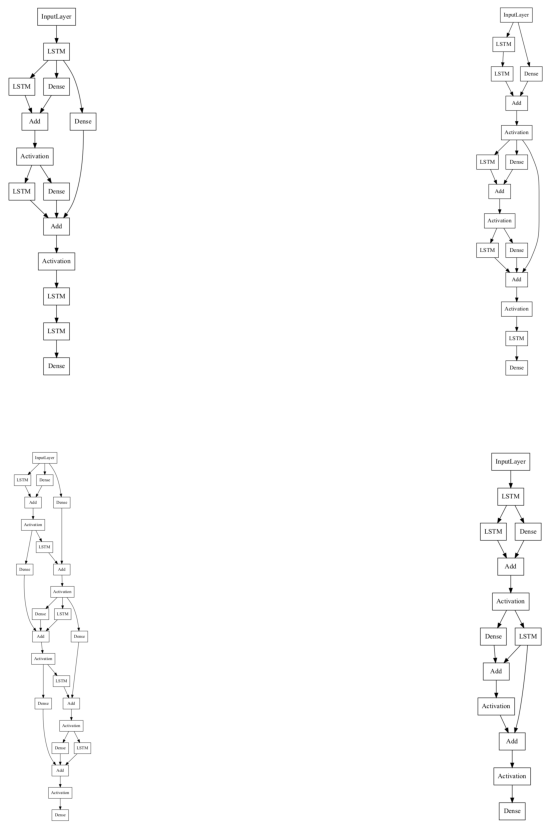

In [15]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(8,5), output_shape=(8,5))
space = StackedLSTMSpace(**shapes).build()

images = []
plt.figure(figsize=(15,15))
for i in range(4):

    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [16]:
from deephyper.problem import NaProblem


problem = NaProblem()

problem.load_data(load_data)


problem.search_space(StackedLSTMSpace)

problem.hyperparameters(
    batch_size=8,
    learning_rate=1e-3,
    optimizer="adam",
    num_epochs=20,
    callbacks=dict(
        ReduceLROnPlateau=dict(
                monitor="val_loss", mode="min", verbose=0, patience=15
        ),
        EarlyStopping=dict(
            monitor="loss", 
            mode="min",
            verbose=0,
            patience=20
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        )
    )
)

problem.loss("mse") 

problem.metrics([]) 

problem.objective('-val_loss') 
problem

Problem is:
    - search space   : __main__.StackedLSTMSpace
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: 8
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 20
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 15}, 'EarlyStopping': {'monitor': 'loss', 'mode': 'min', 'verbose': 0, 'patience': 20}, 'ModelCheckpoint': {'monitor': 'val_loss', 'mode': 'min', 'save_best_only': True, 'verbose': 0, 'filepath': 'model.h5', 'save_weights_only': False}}
    - loss           : mse
    - metrics        : 
    - objective      : -val_loss

Definition of the function to optimize

Execution of a genetic algorithm for the search

In [17]:
from deephyper.search.nas import RegularizedEvolution
from deephyper.nas.run import run_base_trainer


regevo_search = RegularizedEvolution(problem, run_base_trainer, log_dir="regevo-results")
results = regevo_search.search(max_evals=30)

/Users/pbalapra/Projects/repos/2022/tutorials/anl-22-summer-workshop/deephyper/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
results

,arch_seq,job_id,objective,timestamp_submit,timestamp_gather
0,"[5, 1, 5, 1, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0]",1,-0.002883,0.017545,23.023634
1,"[0, 1, 1, 1, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1]",2,-0.003481,23.078995,50.205245
2,"[8, 0, 5, 1, 0, 2, 0, 1, 8, 0, 0, 2, 1, 1]",3,-0.003154,50.207156,89.565543
3,"[3, 0, 1, 0, 1, 5, 0, 1, 5, 1, 1, 8, 0, 0]",4,-0.003382,89.568564,130.785396
4,"[7, 0, 3, 1, 0, 1, 0, 0, 3, 1, 0, 2, 1, 1]",5,-0.003256,130.788055,167.701991
5,"[8, 1, 5, 0, 0, 8, 1, 0, 8, 1, 0, 0, 0, 0]",6,-0.002765,167.704251,205.782298
6,"[2, 1, 5, 0, 0, 6, 0, 0, 8, 0, 1, 5, 1, 1]",7,-0.003063,205.784877,245.672817
7,"[3, 1, 4, 0, 0, 5, 1, 0, 8, 1, 0, 6, 1, 0]",8,-0.002527,245.675315,283.667370
8,"[7, 0, 1, 1, 1, 7, 1, 0, 2, 1, 1, 0, 0, 0]",9,-0.003609,283.669724,313.203071
9,"[3, 1, 0, 0, 1, 6, 1, 0, 5, 1, 0, 1, 1, 1]",10,-0.002813,313.205536,344.423156


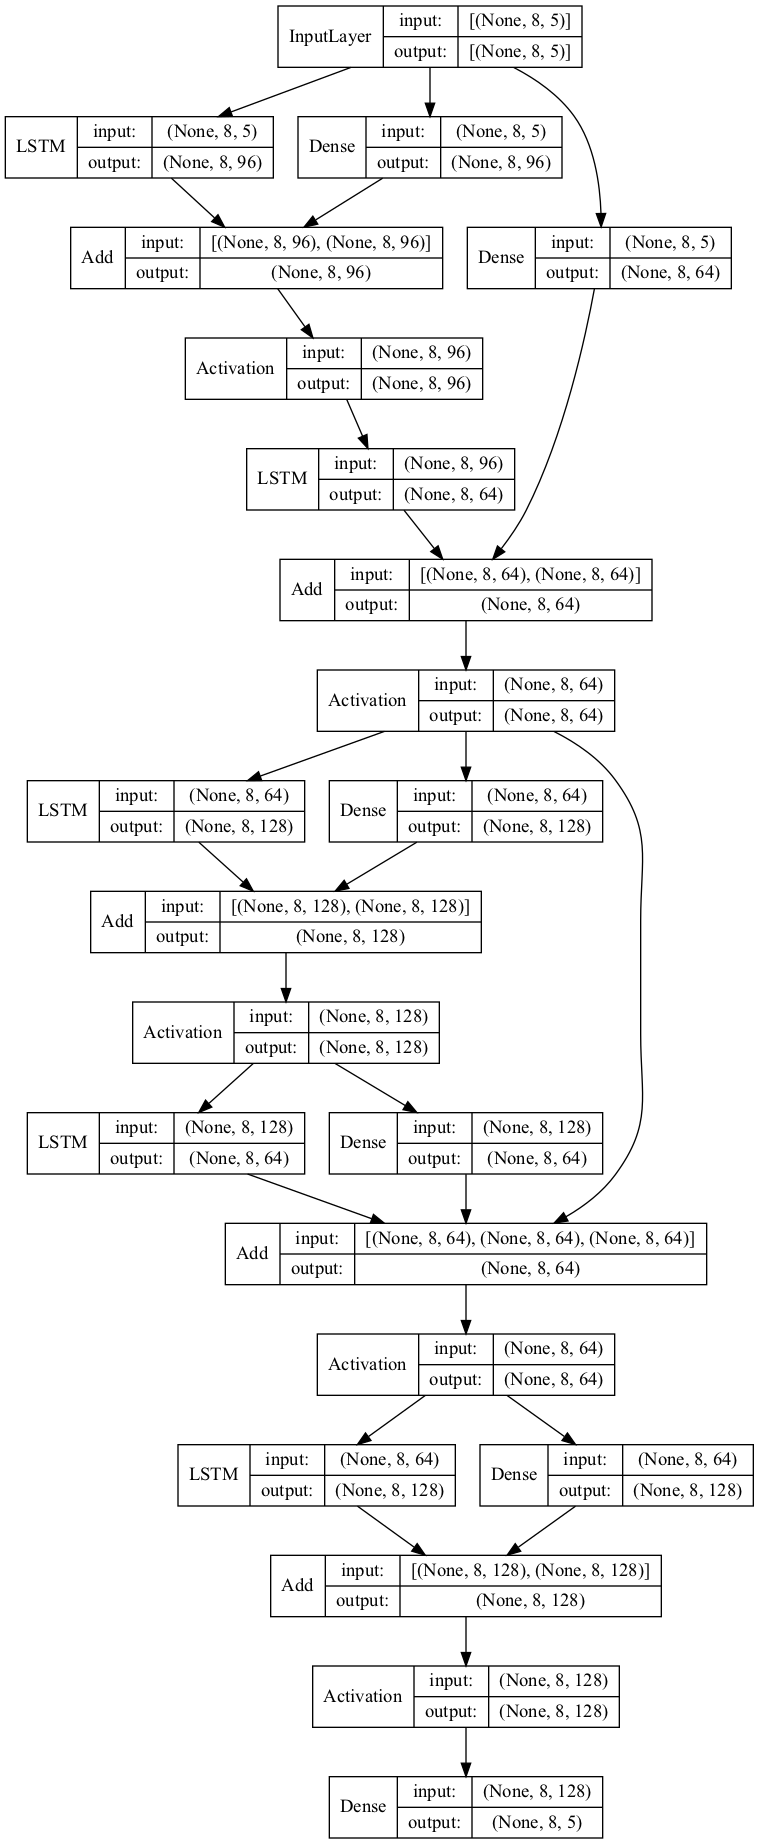

In [19]:
import json


i_max = results.objective.argmax()
best_score = results.iloc[i_max].objective
best_job_id = results.iloc[i_max].job_id
best_arch_seq = json.loads(results.iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)
plot_model(best_model, show_shapes=True, show_layer_names=False)

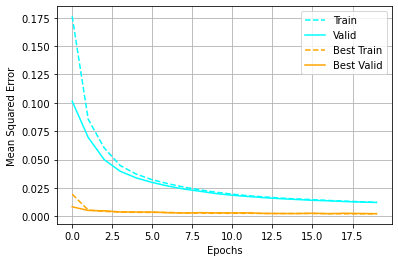

In [20]:
with open(f"regevo-results/save/history/{best_job_id}.json", "r") as f:
    best_history = json.load(f)

plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="--", label="Train")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Valid")
plt.plot(best_history["loss"], color="orange", linestyle="--", label="Best Train")
plt.plot(best_history["val_loss"], color="orange", linestyle="-", label="Best Valid")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show()

In [21]:
best_model = tf.keras.models.load_model(f"regevo-results/save/model/{best_job_id}.h5")

In [22]:
y_pred_best =  best_model.predict(X_train)
shape = y_pred_best.shape
y_pred_best = y_pred_best.reshape(-1, shape[-1])
y_pred_best = preprocessor.inverse_transform(y_pred_best).reshape((*shape[:2], -1))

28/28 [==============================] - 1s 6ms/step


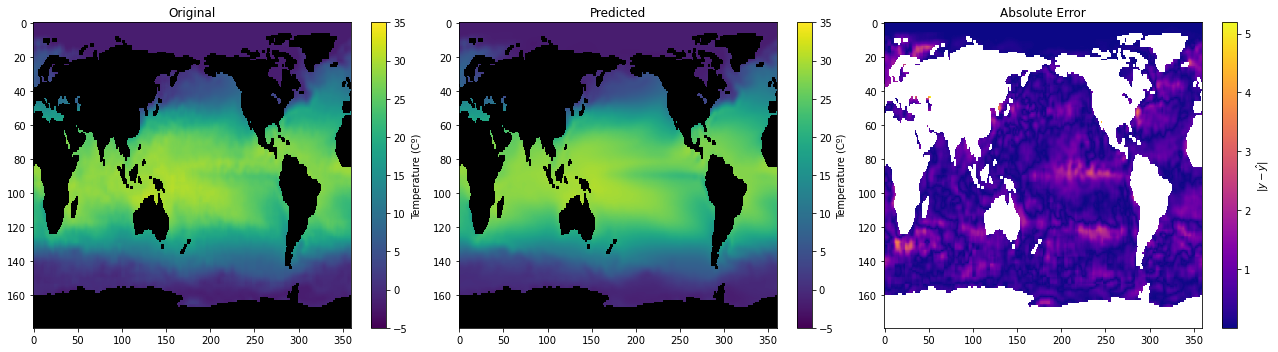

In [23]:
idx = 9 # should be > than input_horizon!
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_y_pred = y_pred_best[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_y_pred.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
ax.set_title("Predicted")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
ax.set_title("Absolute Error")
err = np.abs(snapshot_masked_full - snapshot_masked_redu)
im = plt.imshow(err, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$|y - \hat{y}|$")
plt.tight_layout()

plt.show()

In [24]:
scores = {"MSE": mse, "R2": r2}

for metric_name, metric_func in scores.items():
    print(f"Metric {metric_name}")
    y_pred = best_model.predict(X_train)
    score_train = np.mean(metric_func(y_train, y_pred).numpy())

    y_pred = best_model.predict(X_valid)
    score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

    y_pred = best_model.predict(X_test)
    score_test = np.mean(metric_func(y_test, y_pred).numpy())

    print(f"train: {score_train:.4f}")
    print(f"valid: {score_valid:.4f}")
    print(f"test : {score_test:.4f}")
    print()

Metric MSE
25/25 [==============================] - 0s 6ms/step
score_train=0.002085353
score_valid=0.002338926
score_test=0.00462022

Metric R2
25/25 [==============================] - 0s 6ms/step
score_train=0.9528076
score_valid=0.9487146
score_test=0.8787955

